#### Download manifest from GDC and parsing clincal XML

In [8]:
import os
import sys
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt
import seaborn as sns

script_path = os.path.abspath("../scripts")
if script_path not in sys.path:
    sys.path.append(script_path)

    
from build_tcga_anndata import (
    fetch_mapping_from_manifest,
    merge_counts_with_mapping,
    parse_clinical_xml,
    match_and_save
)
from download_tcga_data import (
    query_gdc_files,
    download_manifest,
    run_gdc_client
)
from annotate_gene_sequences import annotate_sequences_to_adata

#### Download data + Mapping

In [ ]:
tcga_projects = ["TCGA-BRCA", "TCGA-LUAD", "TCGA-LUSC"]

for project in tcga_projects:
    raw_dir = f"../data/raw/{project}"
    os.makedirs(f"{raw_dir}/HTSeq-Counts", exist_ok=True)
    os.makedirs(f"{raw_dir}/Clinical", exist_ok=True)

    # 1. download Expression 
    expr_ids = query_gdc_files(
        project, "Transcriptome Profiling",
        "Gene Expression Quantification", "STAR - Counts"
    )
    expr_manifest = f"{raw_dir}/expr_manifest.txt"
    download_manifest(expr_ids, expr_manifest)
    run_gdc_client(expr_manifest, f"{raw_dir}/HTSeq-Counts")

    # 2. download Clinical
    clin_ids = query_gdc_files(project, "Clinical", "Clinical Supplement")
    clin_manifest = f"{raw_dir}/clin_manifest.txt"
    download_manifest(clin_ids, clin_manifest)
    run_gdc_client(clin_manifest, f"{raw_dir}/Clinical")

    # 3. mapping UUID ↔ barcode
    mapping_csv = f"{raw_dir}/uuid2tcga.csv"
    mapping = fetch_mapping_from_manifest(expr_manifest, mapping_csv)

    # 4. Merge count
    count_csv = f"../data/processed/tcga/{project}_count_matrix.csv"
    merge_counts_with_mapping(f"{raw_dir}/HTSeq-Counts", mapping, count_csv)

    # 5. Merge Clinical XML 
    clin_csv = f"../data/processed/tcga/{project}_clinical_metadata.csv"
    parse_clinical_xml(f"{raw_dir}/Clinical", clin_csv)

    # 6. Mapping gene symbol & Store AnnData
    output_h5ad = f"../data/processed/tcga/{project}_23.h5ad"
    gene_map_csv = "../data/gencode/gene_id_to_symbol_brca.csv"  # 
    match_and_save(count_csv, clin_csv, gene_map_csv, output_h5ad)


#### add sequence in .var based on GENCODE(FASTA)

In [ ]:
fasta_path = "../data/gencode/gencode.v43.pc_transcripts.fa.gz"

for project in tcga_projects:
    input_h5ad = f"../data/processed/tcga/{project}_23.h5ad"
    output_h5ad = f"../data/processed/tcga/{project}_with_seq.h5ad"
    annotate_sequences_to_adata(input_h5ad, fasta_path, output_h5ad)

#### Inspect the structure of the dataset

In [11]:
tcga_projects = ["TCGA-BRCA", "TCGA-LUAD", "TCGA-LUSC"]
def inspect_dataset(name, adata):
    print(f"\n {name} | {adata.n_obs} samples × {adata.n_vars} genes")
    print(".obs columns:", adata.obs.columns.tolist())
    print(".var columns:", adata.var.columns.tolist())
    print("Missing sequences:", adata.var['sequence'].isna().sum())

    # .obs preview
    display(adata.obs.head())
    # .var preview
    display(adata.var[["gene_symbol", "transcript_id", "sequence"]].head())

for project in tcga_projects:
    path = f"../data/archive/{project}_with_seq.h5ad"
    adata = sc.read_h5ad(path)
    inspect_dataset(project, adata)


 TCGA-BRCA | 644 samples × 60664 genes
.obs columns: ['gender', 'age', 'vital_status', 'tumor_stage', 'batch']
.var columns: ['gene_id_x', 'gene_symbol', 'gene_id_y', 'gene_symbol_from_fasta', 'transcript_id', 'sequence']
Missing sequences: 0


,gender,age,vital_status,tumor_stage,batch
TCGA-3C-AAAU,FEMALE,55.0,Alive,Stage X,3C
TCGA-3C-AALI,FEMALE,50.0,Alive,Stage IIB,3C
TCGA-3C-AALJ,FEMALE,62.0,Alive,Stage IIB,3C
TCGA-3C-AALK,FEMALE,52.0,Alive,Stage IA,3C
TCGA-4H-AAAK,FEMALE,50.0,Alive,Stage IIIA,4H


,gene_symbol,transcript_id,sequence
gene_id_clean,,,
N_unmapped,NaN,,
N_multimapping,NaN,,
N_noFeature,NaN,,
N_ambiguous,NaN,,
ENSG00000000003,TSPAN6,ENST00000373020,AGTTGTGGACGCTCGTAAGTTTTCGGCAGTTTCCGGGGAGACTCGG...



 TCGA-LUAD | 418 samples × 60664 genes
.obs columns: ['gender', 'age', 'vital_status', 'tumor_stage', 'batch']
.var columns: ['gene_symbol', 'gene_id', 'gene_symbol_from_fasta', 'transcript_id', 'sequence']
Missing sequences: 0


,gender,age,vital_status,tumor_stage,batch
TCGA-05-4244,MALE,70.0,Alive,Stage IV,05
TCGA-05-4249,MALE,67.0,Alive,Stage IB,05
TCGA-05-4250,FEMALE,79.0,Dead,Stage IIIA,05
TCGA-05-4389,MALE,70.0,Alive,Stage IA,05
TCGA-05-4390,FEMALE,58.0,Alive,Stage IB,05


,gene_symbol,transcript_id,sequence
gene_id_clean,,,
N_unmapped,NaN,,
N_multimapping,NaN,,
N_noFeature,NaN,,
N_ambiguous,NaN,,
ENSG00000000003,TSPAN6,ENST00000373020,AGTTGTGGACGCTCGTAAGTTTTCGGCAGTTTCCGGGGAGACTCGG...



 TCGA-LUSC | 374 samples × 60664 genes
.obs columns: ['gender', 'age', 'vital_status', 'tumor_stage', 'batch']
.var columns: ['gene_symbol', 'gene_id', 'gene_symbol_from_fasta', 'transcript_id', 'sequence']
Missing sequences: 0


,gender,age,vital_status,tumor_stage,batch
TCGA-18-3411,FEMALE,63.0,Alive,Stage IIIA,18
TCGA-18-3412,MALE,52.0,Dead,Stage IB,18
TCGA-18-3414,MALE,73.0,Dead,Stage IV,18
TCGA-18-3415,MALE,77.0,Dead,Stage IB,18
TCGA-18-3417,MALE,65.0,Dead,Stage IV,18


,gene_symbol,transcript_id,sequence
gene_id_clean,,,
N_unmapped,NaN,,
N_multimapping,NaN,,
N_noFeature,NaN,,
N_ambiguous,NaN,,
ENSG00000000003,TSPAN6,ENST00000373020,AGTTGTGGACGCTCGTAAGTTTTCGGCAGTTTCCGGGGAGACTCGG...


#### visualization (UMAP + violin)

/home/ubuntu/.local/lib/python3.10/site-packages/scanpy/preprocessing/_scale.py:309: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
/usr/lib/python3.10/functools.py:889: UserWarning: zero-centering a sparse array/matrix densifies it.
  return dispatch(args[0].__class__)(*args, **kw)


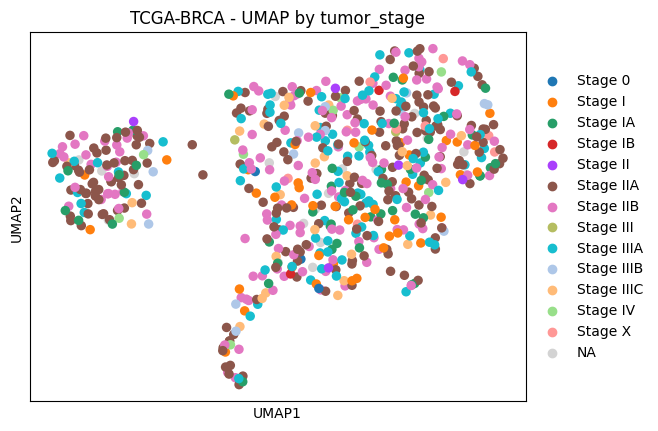

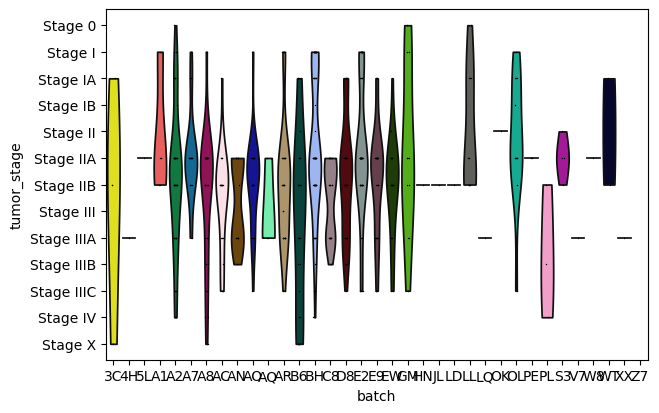

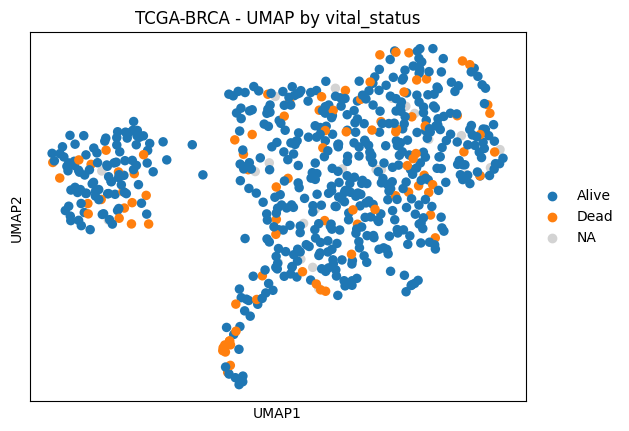

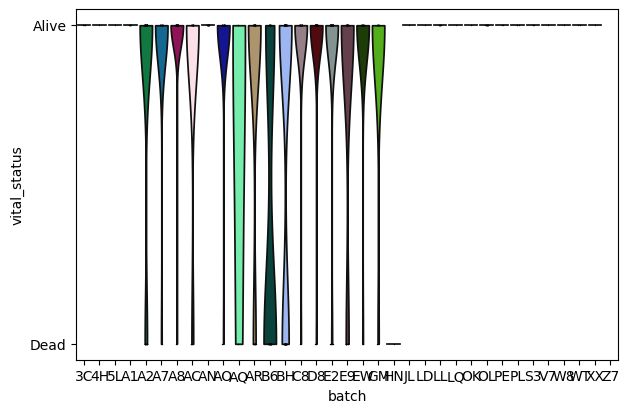

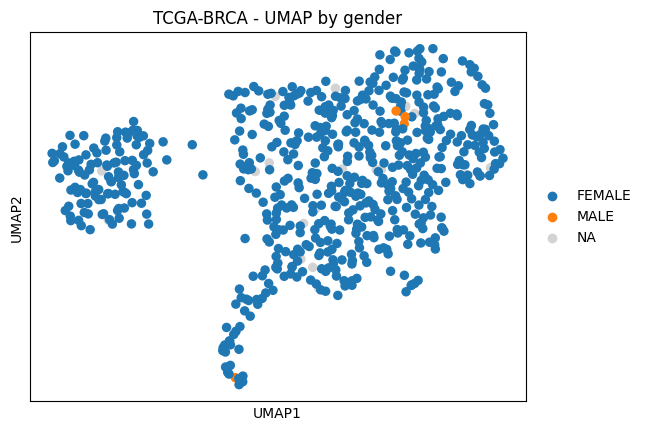

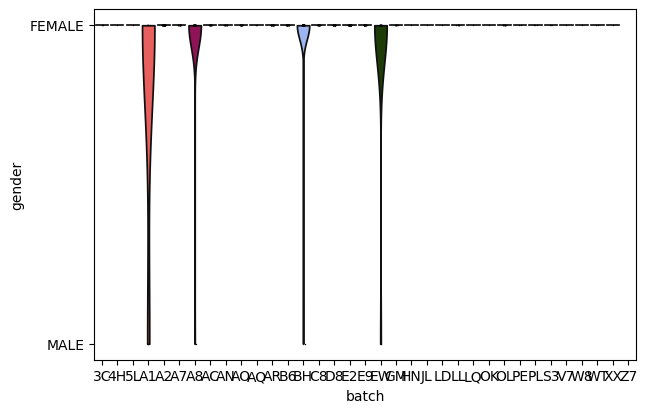

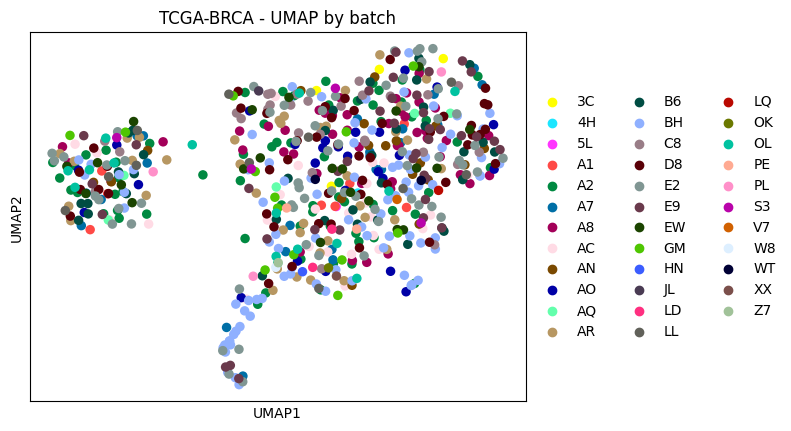

AttributeError: 'DataFrame' object has no attribute 'cat'

In [13]:
def visualize_tcga(adata, name):
    sc.pp.normalize_total(adata, target_sum=1e6)
    sc.pp.log1p(adata)
    sc.pp.highly_variable_genes(adata, n_top_genes=2000)
    adata = adata[:, adata.var.highly_variable]
    sc.pp.scale(adata)
    sc.tl.pca(adata, svd_solver="arpack")
    sc.pp.neighbors(adata)
    sc.tl.umap(adata)

    color_keys = [k for k in ["tumor_stage", "vital_status", "gender", "batch"] if k in adata.obs.columns]
    for key in color_keys:
        sc.pl.umap(adata, color=key, title=f"{name} - UMAP by {key}")
        sc.pl.violin(adata, keys=[key], groupby="batch" if "batch" in adata.obs else None)

for project in tcga_projects:
    path = f"../data/archive/{project}_with_seq.h5ad"
    adata = sc.read_h5ad(path)
    visualize_tcga(adata, project)

In [ ]:
!python ../scripts/build_tcga_anndata.py \
  --counts_dir ../data/raw/tcga/brca \
  --clinical_csv ../data/raw/tcga/brca/clinical_metadata.csv \
  --output ../data/processed/tcga/tcga_brca_raw.h5ad

#### Check the result and inspect the structure

In [1]:
import scanpy as sc
adata = sc.read_h5ad("../data/processed/tcga/tcga_brca_raw.h5ad")

print("AnnData shape:", adata.shape)
print(".obs preview:")
display(adata.obs.head())
print(".var preview:")
display(adata.var.head())

if "tumor_stage" in adata.obs.columns:
    print("Tumor stage breakdown:")
    print(adata.obs["tumor_stage"].value_counts())

FileNotFoundError: [Errno 2] Unable to synchronously open file (unable to open file: name = '../../data/processed/tcga/tcga_brca_raw.h5ad', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

In [ ]:
#### QC Visualization

In [ ]:
def query_gdc_files(project, category, dtype, workflow_type=None):
    filters = {
        "op": "and",
        "content": [
            {"op": "in", "content": {"field": "cases.project.project_id", "value": [project]}},
            {"op": "in", "content": {"field": "files.data_category", "value": [category]}},
            {"op": "in", "content": {"field": "files.data_type", "value": [dtype]}},
            {"op": "in", "content": {"field": "files.access", "value": ["open"]}},
        ]
    }
    if workflow_type:
        filters["content"].append({
            "op": "in",
            "content": {"field": "analysis.workflow_type", "value": [workflow_type]}
        })

    params = {
        "filters": filters,
        "format": "JSON",
        "fields": "file_id",
        "size": 10000
    }
    r = requests.post("https://api.gdc.cancer.gov/files", json=params)
    r.raise_for_status()
    return [x["file_id"] for x in r.json()["data"]["hits"]]

def download_manifest(ids, filename):
    r = requests.post("https://api.gdc.cancer.gov/manifest", json={"ids": ids})
    with open(filename, "wb") as f:
        f.write(r.content)

def run_gdc_client(manifest, output_dir):
    subprocess.run(["gdc-client", "download", "-m", manifest, "-d", output_dir], check=True)

def parse_clinical_xml(xml_dir, output_csv):
    import os
    from glob import glob
    from lxml import etree
    import pandas as pd

    def extract_tss(sample_id):
        parts = sample_id.split("-")
        return parts[1] if len(parts) >= 2 else None

    records = []

    for f in glob(f"{xml_dir}/**/*.xml", recursive=True):
        try:
            filename = os.path.basename(f)
            sample_id = filename.split('.')[-2]  # raw format: TCGA-XX-YYYY-ZZZ...

            tree = etree.parse(f)
            root = tree.getroot()

            # Flatten all XML tags (ignore namespaces)
            text_dict = {elem.tag.split('}')[-1]: elem.text for elem in root.iter()}

            gender = text_dict.get("gender")
            age = text_dict.get("age_at_diagnosis") or text_dict.get("age_at_initial_pathologic_diagnosis")
            vital_status = text_dict.get("vital_status")
            tumor_stage = text_dict.get("clinical_stage") or text_dict.get("pathologic_stage")

            # Normalize sample_id to TCGA-XX-YYYY (first 3 segments only)
            sample_id = "-".join(sample_id.split("-")[:3])
            tss = extract_tss(sample_id)

            records.append({
                "sample_id": sample_id,
                "gender": gender,
                "age": age,
                "vital_status": vital_status,
                "tumor_stage": tumor_stage,
                "batch": tss  # New: TSS as batch label
            })

        except Exception as e:
            print(f"⚠️ Failed parsing {os.path.basename(f)}: {e}")

    if not records:
        print("⚠️ No clinical records were parsed successfully.")
        df = pd.DataFrame(columns=["sample_id", "gender", "age", "vital_status", "tumor_stage", "batch"])
    else:
        df = pd.DataFrame(records).dropna(subset=["sample_id"]).drop_duplicates("sample_id")

    df = df.set_index("sample_id")
    os.makedirs(os.path.dirname(output_csv), exist_ok=True)
    df.to_csv(output_csv)
    print(f"✅ Parsed clinical metadata with TSS batch: {df.shape}")
    return df


def fetch_mapping_from_manifest(manifest_path, output_csv):
    # 1. Abstract UUID 
    with open(manifest_path) as f:
        lines = f.readlines()[1:]  # Skip header
        uuids = [line.split("\t")[0] for line in lines if line.strip()]

    # 2. Using GDC API map UUID → barcode
    url = "https://api.gdc.cancer.gov/files"
    all_records = []
    for i in range(0, len(uuids), 1000):  # GDC request max 1000
        batch = uuids[i:i + 1000]
        filters = {
            "op": "in",
            "content": {"field": "file_id", "value": batch}
        }
        params = {
            "filters": filters,
            "format": "JSON",
            "fields": "file_id,cases.submitter_id",
            "size": len(batch)
        }
        r = requests.post(url, json=params)
        r.raise_for_status()
        hits = r.json()["data"]["hits"]
        for h in hits:
            file_id = h["file_id"]
            case_id = h["cases"][0]["submitter_id"] if h["cases"] else None
            if case_id:
                all_records.append((file_id, case_id))

    # 3. Save
    df = pd.DataFrame(all_records, columns=["uuid", "barcode"]).drop_duplicates("uuid")
    df.to_csv(output_csv, index=False)
    return df.set_index("uuid")["barcode"].to_dict()

def merge_counts_with_mapping(count_dir, mapping, output_csv):
    dfs = []
    for subdir, _, files in os.walk(count_dir):
        for f in files:
            if not f.endswith(".tsv"):
                continue
            path = os.path.join(subdir, f)
            try:
                df = pd.read_csv(path, sep="\t", comment='#')
                if "gene_id" not in df.columns or "unstranded" not in df.columns:
                    continue
                uuid = os.path.basename(subdir)
                if uuid not in mapping:
                    print(f"UUID {uuid} not in barcode mapping. Skipping.")
                    continue
                df = df[["gene_id", "unstranded"]].set_index("gene_id")
                df = df[~df.index.str.startswith("N_")]  
                df.columns = [mapping[uuid]]
                dfs.append(df)
            except Exception as e:
                print(f"Failed to read {path}: {e}")
    if not dfs:
        raise ValueError("No valid count files to merge.")
    merged = pd.concat(dfs, axis=1)
    merged.to_csv(output_csv)
    print(f"Merged count matrix saved: {merged.shape}")
    return merged

def merge_counts_with_mapping(count_dir, mapping, output_csv):
    dfs = []
    for subdir, _, files in os.walk(count_dir):
        uuid = os.path.basename(subdir)
        if uuid not in mapping:
            continue
        barcode = mapping[uuid]
        sample_id = "-".join(barcode.split("-")[:3])  # Normalize with the format TCGA-XX-YYYY 

        for f in files:
            if not f.endswith(".tsv"):
                continue
            path = os.path.join(subdir, f)
            try:
                df = pd.read_csv(path, sep="\t", comment="#")
                if "gene_id" not in df.columns or "unstranded" not in df.columns:
                    continue
                df = df[["gene_id", "unstranded"]].set_index("gene_id")
                df.columns = [sample_id]
                dfs.append(df)
            except Exception as e:
                print(f"⚠️ Failed to process {path}: {e}")

    if not dfs:
        raise ValueError("No valid count files merged.")
    merged = pd.concat(dfs, axis=1)
    merged.to_csv(output_csv)
    print(f"✅ Merged count matrix saved: {merged.shape}")
    return merged

def match_and_save(count_csv, clin_csv, gene_mapping_csv, output_h5ad):
    import pandas as pd
    import numpy as np
    from scipy import sparse
    import anndata as ad
    import os

    # Load count matrix and clinical metadata
    counts = pd.read_csv(count_csv, index_col=0)
    metadata = pd.read_csv(clin_csv, index_col=0)
    gene_map = pd.read_csv(gene_mapping_csv)  # columns: gene_id, gene_symbol

    # Normalize sample IDs
    counts.columns = ["-".join(c.split("-")[:3]) for c in counts.columns]
    metadata.index = ["-".join(i.split("-")[:3]) for i in metadata.index]

    # Match common samples
    common = sorted(set(counts.columns).intersection(metadata.index))
    if not common:
        raise ValueError("No matching sample IDs between counts and metadata.")
    counts = counts[common]
    metadata = metadata.loc[common]

    # Build var with gene symbol mapping
    gene_map = gene_map.drop_duplicates("ensembl_gene_id").set_index("ensembl_gene_id")
    # var = pd.DataFrame(index=counts.index)
    # var["gene_id"] = counts.index.str.replace(r"\.\d+$", "", regex=True)  # 버전 제거
    # var["gene_symbol"] = var["gene_id"].map(gene_map["hgnc_symbol"])
    var = pd.DataFrame(index=counts.index)
    var.index.name = "gene_id"  # 명시적으로 지정
    var["gene_id_clean"] = counts.index.str.replace(r"\.\d+$", "", regex=True)  # 버전 제거
    var["gene_symbol"] = var["gene_id_clean"].map(gene_map["hgnc_symbol"])

    # Create expression matrix (cells × genes)
    X = sparse.csr_matrix(counts.T.fillna(0).astype(np.float32))

    # Create AnnData
    adata = ad.AnnData(X=X, obs=metadata, var=var)
    os.makedirs(os.path.dirname(output_h5ad), exist_ok=True)
    adata.write(output_h5ad)
    print(f"✅ AnnData saved: {adata.n_obs} samples × {adata.n_vars} genes → {output_h5ad}")
    return adata


def run_pipeline(project):
    os.makedirs("results", exist_ok=True)
    root = os.path.abspath(f"../data/raw/{project}")
    os.makedirs(f"{root}/HTSeq-Counts", exist_ok=True)
    os.makedirs(f"{root}/Clinical", exist_ok=True)

    print("Querying expression file UUIDs...")
    expr_ids = query_gdc_files(project, "Transcriptome Profiling", "Gene Expression Quantification", "STAR - Counts")
    download_manifest(expr_ids, f"{root}/expr_manifest.txt")
    run_gdc_client(f"{root}/expr_manifest.txt", f"{root}/HTSeq-Counts")

    print("Querying clinical file UUIDs...")
    clin_ids = query_gdc_files(project, "Clinical", "Clinical Supplement")
    download_manifest(clin_ids, f"{root}/clin_manifest.txt")
    run_gdc_client(f"{root}/clin_manifest.txt", f"{root}/Clinical")

    print("Fetching mapping table...")
    mapping = fetch_mapping_from_manifest(
    manifest_path=f"{root}/expr_manifest.txt",
    output_csv=f"{root}/uuid2tcga.csv"
    )

    print("Merging count files...")
    count_csv = f"results/{project}_count_matrix.csv"
    merge_counts_with_mapping(f"{root}/HTSeq-Counts", mapping, count_csv)

    print("Parsing clinical metadata...")
    clin_csv = f"results/{project}_clinical_metadata.csv"
    parse_clinical_xml(f"{root}/Clinical", clin_csv)
    output_h5ad = f"results/{project}_23.h5ad"
    
    print("Creating AnnData object...")
    gene_mapping_csv = "gene_id_to_symbol_brca.csv"
    match_and_save(count_csv, clin_csv, gene_mapping_csv, output_h5ad)




In [ ]:
tcga_lst = ["TCGA-BRCA", "TCGA-LUAD", "TCGA-LUSC"]

for cancer_type in tcga_lst:
    run_pipeline(cancer_type)

### Preprocess (adding sequences to .var)
- Map to Sequences using GENCODE FASTA
- For each gene_id, select the representative transcript and extract gene_symbol, transcript_id, and nucleotide_sequence
- Merge this information into .var of the AnnData object

In [2]:
# !wget ftp://ftp.ebi.ac.uk/pub/databases/gencode/Gencode_human/release_43/gencode.v43.pc_transcripts.fa.gz
# !wget ftp://ftp.ebi.ac.uk/pub/databases/gencode/Gencode_human/release_43/gencode.v43.annotation.gtf.gz

--2025-07-03 17:20:52--  ftp://ftp.ebi.ac.uk/pub/databases/gencode/Gencode_human/release_43/gencode.v43.pc_transcripts.fa.gz
           => ‘gencode.v43.pc_transcripts.fa.gz’
Resolving ftp.ebi.ac.uk (ftp.ebi.ac.uk)... 193.62.193.165
Connecting to ftp.ebi.ac.uk (ftp.ebi.ac.uk)|193.62.193.165|:21... connected.
Logging in as anonymous ... Logged in!
==> SYST ... done.    ==> PWD ... done.
==> TYPE I ... done.  ==> CWD (1) /pub/databases/gencode/Gencode_human/release_43 ... done.
==> SIZE gencode.v43.pc_transcripts.fa.gz ... 47847292
==> PASV ... done.    ==> RETR gencode.v43.pc_transcripts.fa.gz ... done.
Length: 47847292 (46M) (unauthoritative)

gencode.v43.pc_tran 100%[===================>]  45.63M  55.0MB/s    in 0.8s    

2025-07-03 17:20:53 (55.0 MB/s) - ‘gencode.v43.pc_transcripts.fa.gz’ saved [47847292]

--2025-07-03 17:20:53--  ftp://ftp.ebi.ac.uk/pub/databases/gencode/Gencode_human/release_43/gencode.v43.annotation.gtf.gz
           => ‘gencode.v43.annotation.gtf.gz’
Resolving ftp

In [ ]:
from Bio import SeqIO
import pandas as pd
import anndata as ad
import gzip
import re
import os

In [12]:
# FASTA path
fasta_path = "gencode.v43.pc_transcripts.fa.gz"

# STEP 1: Load AnnData
adata = ad.read_h5ad(adata_path)
print(f"✅ Loaded AnnData: {adata.shape}")

# STEP 2: get gene_id ↔ sequence, symbol, transcript_id from FASTA
def extract_gene_sequences_extended(fasta_path):
    rows = []
    with gzip.open(fasta_path, "rt") as handle:
        for record in SeqIO.parse(handle, "fasta"):
            try:
                parts = record.description.split("|")
                if len(parts) < 6:
                    continue
                transcript_id = parts[0].split(".")[0]
                gene_id = parts[1].split(".")[0]
                gene_symbol = parts[5]
                rows.append({
                    "gene_id": gene_id,
                    "gene_symbol_from_fasta": gene_symbol,
                    "transcript_id": transcript_id,
                    "sequence": str(record.seq)
                })
            except Exception:
                continue
    df = pd.DataFrame(rows).drop_duplicates("gene_id")
    print(f"✅ Extracted {len(df)} gene_id ↔ sequence mappings")
    return df

seq_df = extract_gene_sequences_extended(fasta_path)

# STEP 3: Merge
if "gene_id_clean" not in adata.var.columns:
    adata.var["gene_id_clean"] = adata.var.index.str.replace(r"\.\d+$", "", regex=True)

adata.var = adata.var.merge(seq_df, left_on="gene_id_clean", right_on="gene_id", how="left")

# STEP 4: Overwrite sequence_y → sequence
adata.var["sequence"] = adata.var["sequence"]
adata.var["sequence"] = adata.var["sequence"].fillna("")

# copy gene_symbol_from_fasta and transcript_id (Optional)
adata.var["gene_symbol_from_fasta"] = adata.var["gene_symbol_from_fasta"].fillna("")
adata.var["transcript_id"] = adata.var["transcript_id"].fillna("")

# STEP 5: delete unnecessary columns
drop_cols = [c for c in ["sequence_x", "sequence_y"] if c in adata.var.columns]
adata.var.drop(columns=drop_cols, inplace=True)

# STEP 6: Save the output
adata.var.set_index("gene_id_clean", inplace=True)
adata.write(output_path)
print(f"✅ Final AnnData saved with sequence: {output_path}")


✅ Loaded AnnData: (374, 60664)
✅ Extracted 20377 gene_id ↔ sequence mappings
✅ Final AnnData saved with sequence: ../data/preprocessed/TCGA-LUSC_23_with_seq.h5ad


### Check the outputs

In [14]:
import anndata as ad
import pandas as pd
import numpy as np
import os

def load_and_summarize_tcga_data(cohort):
    adata_path = f"../data/preprocessed/TCGA-{cohort}_23_with_seq.h5ad"

    if not os.path.exists(adata_path):
        print(f"File not found for cohort: {cohort}")
        return

    adata = ad.read_h5ad(adata_path)
    print(f"\n==================== TCGA-{cohort} ====================")
    print(f"AnnData shape: {adata.n_obs} samples × {adata.n_vars} genes")

    # .obs
    print("\nSample-level Metadata (.obs):")
    display(adata.obs.head())

    # .var
    print("\nGene-level Metadata (.var):")
    display(adata.var[["gene_symbol", "transcript_id", "sequence"]].head())

    # .X
    print("\nExpression matrix (.X):")
    print(f"- Type: {type(adata.X)}")
    print(f"- Shape: {adata.X.shape}")

    # Sanity check
    if hasattr(adata.X, "mean"):
        avg_expr = adata.X.mean(axis=0)
        print(f"- Mean expression per gene (first 5): {np.array(avg_expr).flatten()[:5]}")
    print("=======================================================\n")

# Run for each cohort
for cohort in ["BRCA", "LUAD", "LUSC"]:
    load_and_summarize_tcga_data(cohort)


==================== TCGA-BRCA ====================
AnnData shape: 644 samples × 60664 genes

Sample-level Metadata (.obs):


,gender,age,vital_status,tumor_stage,batch
TCGA-3C-AAAU,FEMALE,55.0,Alive,Stage X,3C
TCGA-3C-AALI,FEMALE,50.0,Alive,Stage IIB,3C
TCGA-3C-AALJ,FEMALE,62.0,Alive,Stage IIB,3C
TCGA-3C-AALK,FEMALE,52.0,Alive,Stage IA,3C
TCGA-4H-AAAK,FEMALE,50.0,Alive,Stage IIIA,4H



Gene-level Metadata (.var):


,gene_symbol,transcript_id,sequence
gene_id_clean,,,
N_unmapped,NaN,,
N_multimapping,NaN,,
N_noFeature,NaN,,
N_ambiguous,NaN,,
ENSG00000000003,TSPAN6,ENST00000373020,AGTTGTGGACGCTCGTAAGTTTTCGGCAGTTTCCGGGGAGACTCGG...



Expression matrix (.X):
- Type: <class 'scipy.sparse._csr.csr_matrix'>
- Shape: (644, 60664)
- Mean expression per gene (first 5): [3.0199198e+06 5.4297695e+06 3.3345265e+06 6.4258045e+06 3.1286003e+03]


==================== TCGA-LUAD ====================
AnnData shape: 418 samples × 60664 genes

Sample-level Metadata (.obs):


,gender,age,vital_status,tumor_stage,batch
TCGA-05-4244,MALE,70.0,Alive,Stage IV,05
TCGA-05-4249,MALE,67.0,Alive,Stage IB,05
TCGA-05-4250,FEMALE,79.0,Dead,Stage IIIA,05
TCGA-05-4389,MALE,70.0,Alive,Stage IA,05
TCGA-05-4390,FEMALE,58.0,Alive,Stage IB,05



Gene-level Metadata (.var):


,gene_symbol,transcript_id,sequence
gene_id_clean,,,
N_unmapped,NaN,,
N_multimapping,NaN,,
N_noFeature,NaN,,
N_ambiguous,NaN,,
ENSG00000000003,TSPAN6,ENST00000373020,AGTTGTGGACGCTCGTAAGTTTTCGGCAGTTTCCGGGGAGACTCGG...



Expression matrix (.X):
- Type: <class 'scipy.sparse._csr.csr_matrix'>
- Shape: (418, 60664)
- Mean expression per gene (first 5): [2.2551462e+06 5.5280700e+06 3.7052702e+06 5.5504225e+06 3.4360671e+03]


==================== TCGA-LUSC ====================
AnnData shape: 374 samples × 60664 genes

Sample-level Metadata (.obs):


,gender,age,vital_status,tumor_stage,batch
TCGA-18-3411,FEMALE,63.0,Alive,Stage IIIA,18
TCGA-18-3412,MALE,52.0,Dead,Stage IB,18
TCGA-18-3414,MALE,73.0,Dead,Stage IV,18
TCGA-18-3415,MALE,77.0,Dead,Stage IB,18
TCGA-18-3417,MALE,65.0,Dead,Stage IV,18



Gene-level Metadata (.var):


,gene_symbol,transcript_id,sequence
gene_id_clean,,,
N_unmapped,NaN,,
N_multimapping,NaN,,
N_noFeature,NaN,,
N_ambiguous,NaN,,
ENSG00000000003,TSPAN6,ENST00000373020,AGTTGTGGACGCTCGTAAGTTTTCGGCAGTTTCCGGGGAGACTCGG...



Expression matrix (.X):
- Type: <class 'scipy.sparse._csr.csr_matrix'>
- Shape: (374, 60664)
- Mean expression per gene (first 5): [2.9733298e+06 6.2443755e+06 3.1555430e+06 6.1270780e+06 3.5797058e+03]



mkdir -p failed for path /mnt/data/.cache/matplotlib: [Errno 13] Permission denied: '/mnt/data/.cache'
Matplotlib created a temporary cache directory at /tmp/matplotlib-atx_dedm because there was an issue with the default path (/mnt/data/.cache/matplotlib); it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


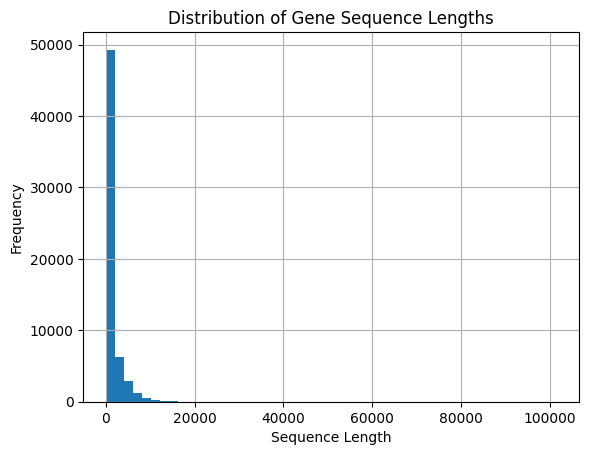

In [5]:
import matplotlib.pyplot as plt

adata.var['sequence_length'].hist(bins=50)
plt.title("Distribution of Gene Sequence Lengths")
plt.xlabel("Sequence Length")
plt.ylabel("Frequency")
plt.show()

In [1]:
'''
# Checking the output
.X : shape - cells x genes
.obs : batch, gender, age, tumor_stage
.var : gene-level info with index=gene symbol or Ensembl ID (gene_ids, gene_id_clean, and seqeunce)
.var['sequence'] : check how many sequence is missing - coverage should be >= 99% 

'''

import scanpy as sc
import pandas as pd
import numpy as np
from scipy.sparse import issparse


adata_brca = sc.read_h5ad("../data/preprocessed/TCGA-BRCA_23_with_seq.h5ad")
adata_luad = sc.read_h5ad("../data/preprocessed/TCGA-LUAD_23_with_seq.h5ad")
adata_lusc = sc.read_h5ad("../data/preprocessed/TCGA-LUSC_23_with_seq.h5ad")

datasets = {
    "BRCA": adata_brca,
    "LUAD": adata_luad,
    "LUSC": adata_lusc
}


def inspect_dataset(name, adata):
    print(f"\n Dataset: {name}")
    print("Shape:", adata.shape)

    # X matrix
    if issparse(adata.X):
        nonzeros = adata.X.nnz
        print(f".X is sparse. Non-zero elements: {nonzeros}")
    else:
        print(".X is dense.")

    # .var
    required_var_keys = {"gene_ids", "gene_id_clean", "sequence"}
    var_keys = set(adata.var.columns)
    print(".var keys:", var_keys)
    missing_keys = required_var_keys - var_keys
    if missing_keys:
        print(f"Missing .var keys: {missing_keys}")
    else:
        missing_seq = adata.var["sequence"].isna().sum() + (adata.var["sequence"] == "").sum()
        print(f"sequence column present. Missing sequences: {missing_seq} / {adata.var.shape[0]}")

    # .obs
    print("\n.obs shape:", adata.obs.shape)
    obs_preview = adata.obs.head()
    print(obs_preview)

    # check for useful .obs fields
    for field in ["batch", "age", "gender", "percent_mito", "cell_type"]:
        if field in adata.obs.columns:
            print(f".obs['{field}'] present.")
        else:
            print(f".obs['{field}'] missing.")


for name, adata in datasets.items():
    inspect_dataset(name, adata)



 Dataset: BRCA
Shape: (644, 60664)
.X is sparse. Non-zero elements: 20968018
.var keys: {'gene_id_y', 'sequence', 'gene_id_x', 'gene_symbol_from_fasta', 'gene_symbol', 'transcript_id'}
Missing .var keys: {'gene_ids', 'gene_id_clean'}

.obs shape: (644, 5)
              gender   age vital_status tumor_stage batch
TCGA-3C-AAAU  FEMALE  55.0        Alive     Stage X    3C
TCGA-3C-AALI  FEMALE  50.0        Alive   Stage IIB    3C
TCGA-3C-AALJ  FEMALE  62.0        Alive   Stage IIB    3C
TCGA-3C-AALK  FEMALE  52.0        Alive    Stage IA    3C
TCGA-4H-AAAK  FEMALE  50.0        Alive  Stage IIIA    4H
.obs['batch'] present.
.obs['age'] present.
.obs['gender'] present.
.obs['percent_mito'] missing.
.obs['cell_type'] missing.

 Dataset: LUAD
Shape: (418, 60664)
.X is sparse. Non-zero elements: 13715130
.var keys: {'sequence', 'gene_symbol_from_fasta', 'gene_symbol', 'gene_id', 'transcript_id'}
Missing .var keys: {'gene_ids', 'gene_id_clean'}

.obs shape: (418, 5)
              gender   age v

In [10]:
# Check example values from PBMC dataset
print("TCGA: .var index:", adata_brca.var.index[:5])
print(": .var['gene_id_clean']:", adata_brca.var['gene_id_clean'].unique()[:5])
# print("PBMC: .var['gene_ids'] sample:")
# print(adata_pbmc.var['gene_ids'].explode().unique()[:5])

TCGA: .var index: Index(['N_unmapped', 'N_multimapping', 'N_noFeature', 'N_ambiguous',
       'ENSG00000000003'],
      dtype='object', name='gene_id_clean')
: .var['gene_id_y']: [NaN, 'ENSG00000000003', 'ENSG00000000005', 'ENSG00000000419', 'ENSG00000000457']
Categories (20270, object): ['ENSG00000000003', 'ENSG00000000005', 'ENSG00000000419', 'ENSG00000000457', ..., 'ENSG00000288669', 'ENSG00000288671', 'ENSG00000288674', 'ENSG00000288675']


In [19]:
import scanpy as sc
import pandas as pd

output_dir = "../data/preprocessed/"
import os
os.makedirs(output_dir, exist_ok=True)

# Load datasets
adata_brca = sc.read_h5ad("../data/preprocessed/TCGA-BRCA_23_with_seq.h5ad")
adata_luad = sc.read_h5ad("../data/preprocessed/TCGA-LUAD_23_with_seq.h5ad")
adata_lusc = sc.read_h5ad("../data/preprocessed/TCGA-LUSC_23_with_seq.h5ad")

datasets = {
    "BRCA": adata_brca,
    "LUAD": adata_luad,
    "LUSC": adata_lusc
}

# Harmonization function
def harmonize_var(adata):
    # Step 1: Drop unwanted non-gene rows
    adata = adata[:, ~adata.var.index.str.startswith("N_")].copy()


    # Step 2: Assign gene_id
    if "gene_id_y" in adata.var.columns:
        adata.var["gene_id"] = adata.var["gene_id_y"]
    elif "gene_id" in adata.var.columns:
        pass  # already present
    else:
        raise ValueError("No usable 'gene_id' column in .var")

    # Step 3: Clean and standardize
    adata.var["gene_id_clean"] = adata.var["gene_id"].astype(str).str.strip().str.upper()
    adata.var["gene_ids"] = adata.var["gene_id_clean"].apply(lambda x: [x] if pd.notnull(x) else [])
    # convert list of strings to comma separated string for saving
    adata.var["gene_ids"] = adata.var["gene_ids"].apply(lambda x: ",".join(x) if isinstance(x, list) else "")
    # to avoid index/column name collision
    adata.var.index.name = None
    
    return adata

# Apply to all datasets
for name, adata in datasets.items():
    print(f"\nHarmonizing {name}")
    adata = harmonize_var(adata)

    print(".var keys:", adata.var.columns.tolist())
    print("gene_id_clean example:", adata.var["gene_id_clean"].unique()[:5])
    print("gene_ids example:", adata.var["gene_ids"].explode().unique()[:5])

    # Save to file
    output_path = os.path.join(output_dir, f"TCGA-{name}_final.h5ad")
    adata.write(output_path)
    print(f"Saved: {output_path}")

    # Update in dictionary (optional if you plan to reuse)
    datasets[name] = adata



Harmonizing BRCA
.var keys: ['gene_id_x', 'gene_symbol', 'gene_id_y', 'gene_symbol_from_fasta', 'transcript_id', 'sequence', 'gene_id', 'gene_id_clean', 'gene_ids']
gene_id_clean example: ['ENSG00000000003' 'ENSG00000000005' 'ENSG00000000419' 'ENSG00000000457'
 'ENSG00000000460']
gene_ids example: ['ENSG00000000003' 'ENSG00000000005' 'ENSG00000000419' 'ENSG00000000457'
 'ENSG00000000460']
Saved: ../data/preprocessed/TCGA-BRCA_final.h5ad

Harmonizing LUAD
.var keys: ['gene_symbol', 'gene_id', 'gene_symbol_from_fasta', 'transcript_id', 'sequence', 'gene_id_clean', 'gene_ids']
gene_id_clean example: ['ENSG00000000003' 'ENSG00000000005' 'ENSG00000000419' 'ENSG00000000457'
 'ENSG00000000460']
gene_ids example: ['ENSG00000000003' 'ENSG00000000005' 'ENSG00000000419' 'ENSG00000000457'
 'ENSG00000000460']
Saved: ../data/preprocessed/TCGA-LUAD_final.h5ad

Harmonizing LUSC
.var keys: ['gene_symbol', 'gene_id', 'gene_symbol_from_fasta', 'transcript_id', 'sequence', 'gene_id_clean', 'gene_ids']
ge

In [16]:
# Check example values from PBMC dataset
print("TCGA: .var index:", adata_brca.var.index[:5])
print(": .var['gene_id_clean']:", adata_brca.var['gene_id_clean'].unique()[:5])
# print("PBMC: .var['gene_ids'] sample:")
# print(adata_pbmc.var['gene_ids'].explode().unique()[:5])

TCGA: .var index: Index(['N_unmapped', 'N_multimapping', 'N_noFeature', 'N_ambiguous',
       'ENSG00000000003'],
      dtype='object', name='gene_id_clean')


KeyError: 'gene_id_clean'

In [6]:
adata_brca.var['gene_ids']

gene_id_clean
N_unmapped                     [NAN]
N_multimapping                 [NAN]
N_noFeature                    [NAN]
N_ambiguous                    [NAN]
ENSG00000000003    [ENSG00000000003]
                         ...        
ENSG00000288669    [ENSG00000288669]
ENSG00000288670                [NAN]
ENSG00000288671    [ENSG00000288671]
ENSG00000288674    [ENSG00000288674]
ENSG00000288675    [ENSG00000288675]
Name: gene_ids, Length: 60664, dtype: object

In [7]:
adata_brca.var['gene_id_clean']

gene_id_clean
N_unmapped                     NAN
N_multimapping                 NAN
N_noFeature                    NAN
N_ambiguous                    NAN
ENSG00000000003    ENSG00000000003
                        ...       
ENSG00000288669    ENSG00000288669
ENSG00000288670                NAN
ENSG00000288671    ENSG00000288671
ENSG00000288674    ENSG00000288674
ENSG00000288675    ENSG00000288675
Name: gene_id_clean, Length: 60664, dtype: object


📊 Visualizing: TCGA-BRCA
.obs columns: ['gender', 'age', 'vital_status', 'tumor_stage', 'batch']


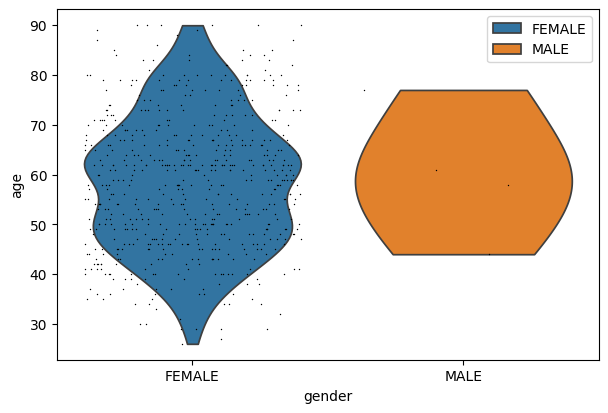

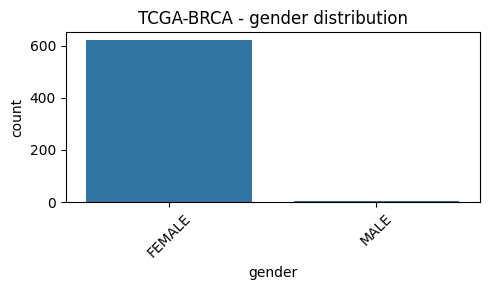

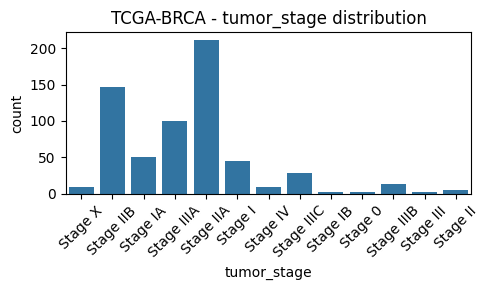

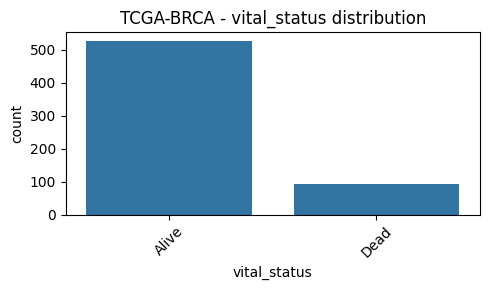

/home/ubuntu/.local/lib/python3.10/site-packages/scanpy/preprocessing/_scale.py:309: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
/usr/lib/python3.10/functools.py:889: UserWarning: zero-centering a sparse array/matrix densifies it.
  return dispatch(args[0].__class__)(*args, **kw)


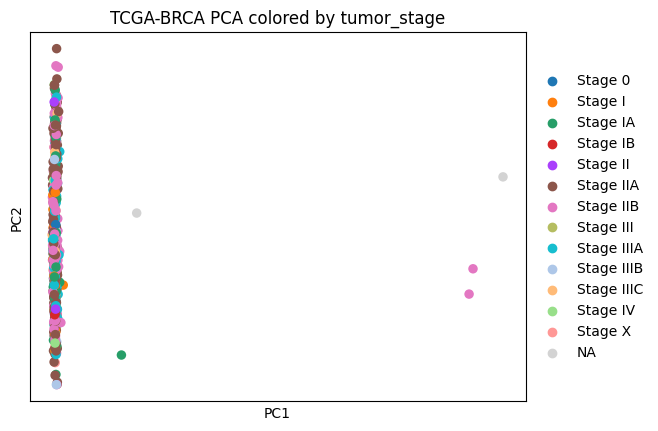

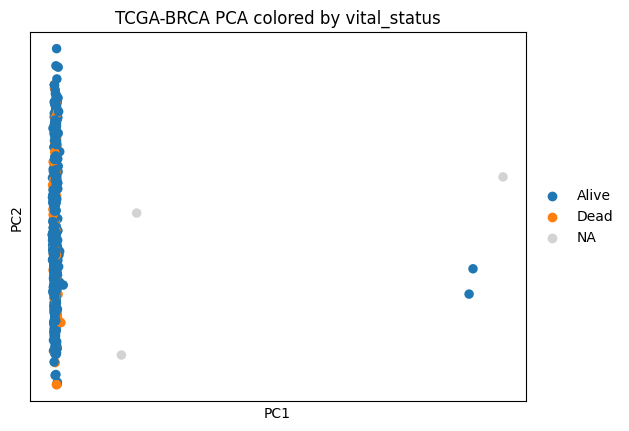

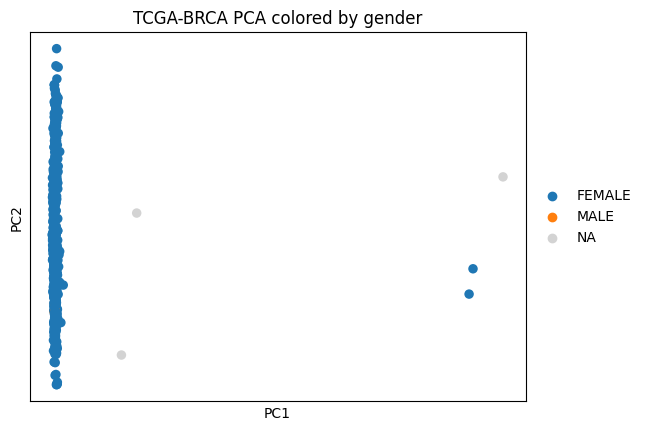

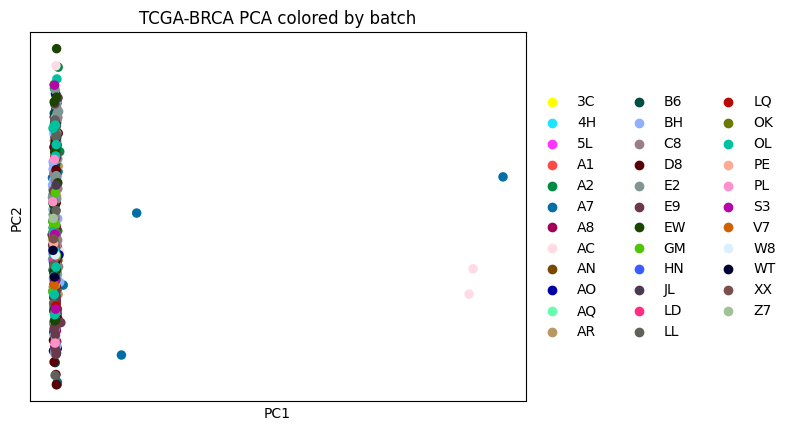

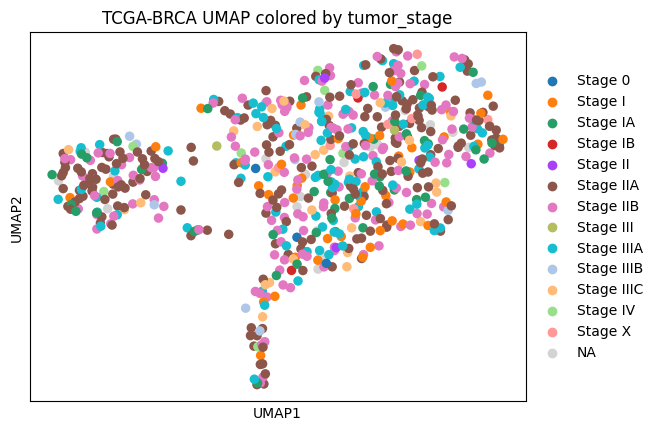

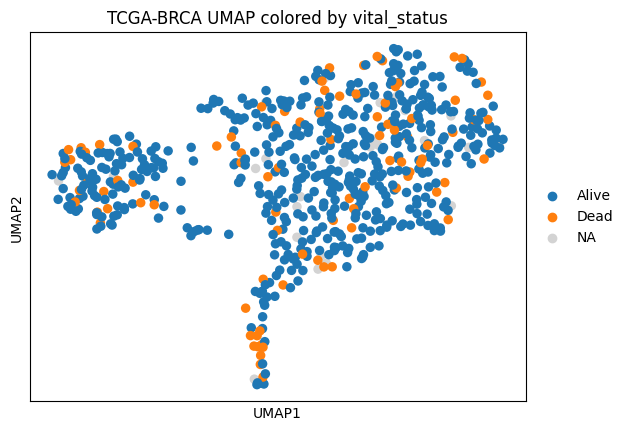

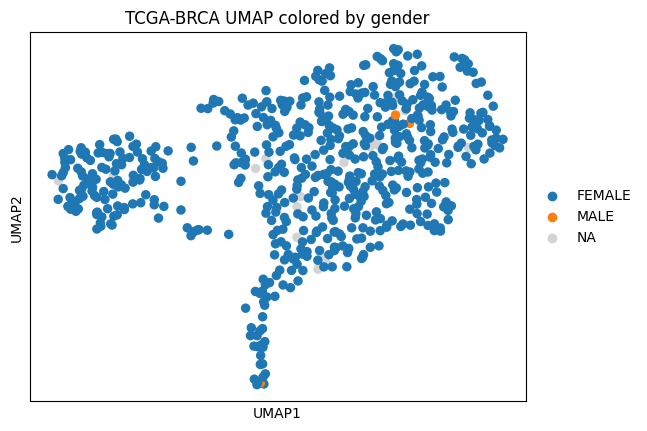

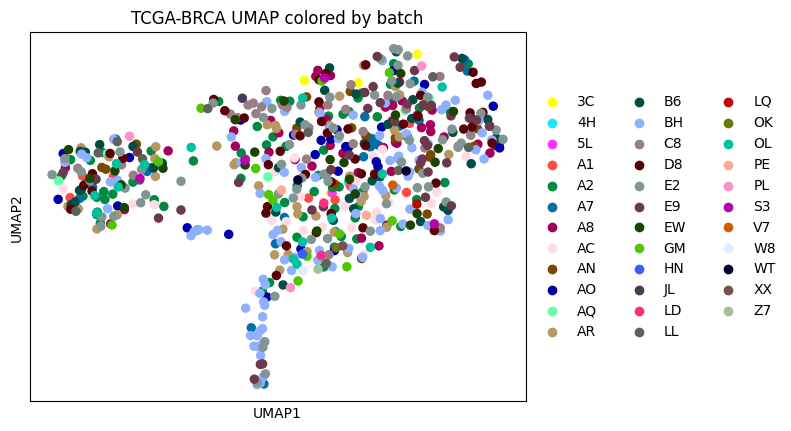

✅ Visualization complete for TCGA-BRCA.

📊 Visualizing: TCGA-LUAD
.obs columns: ['gender', 'age', 'vital_status', 'tumor_stage', 'batch']


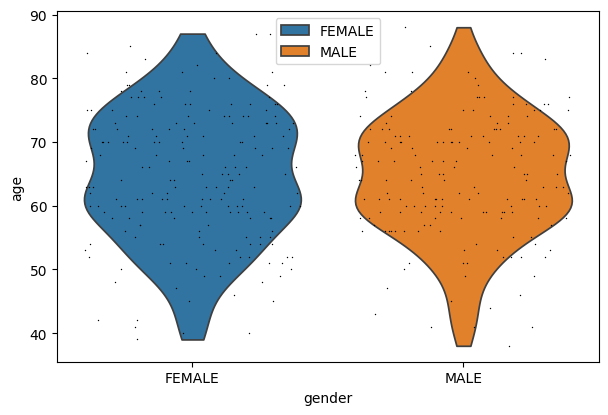

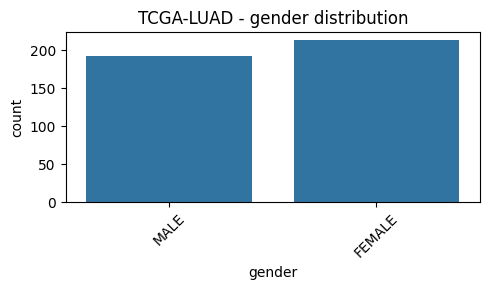

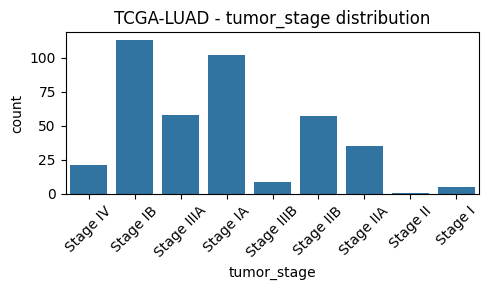

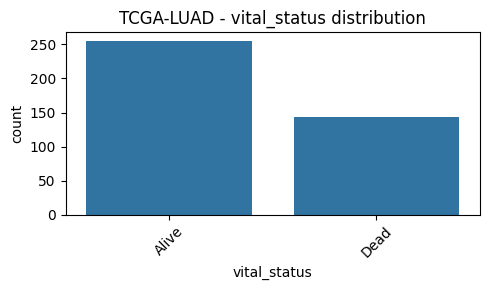

/home/ubuntu/.local/lib/python3.10/site-packages/scanpy/preprocessing/_scale.py:309: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
/usr/lib/python3.10/functools.py:889: UserWarning: zero-centering a sparse array/matrix densifies it.
  return dispatch(args[0].__class__)(*args, **kw)


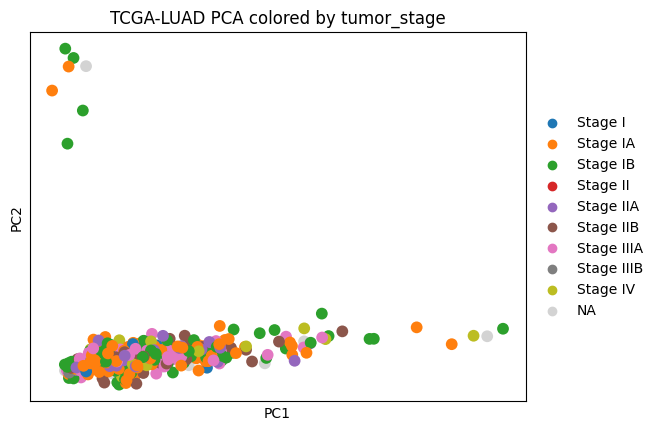

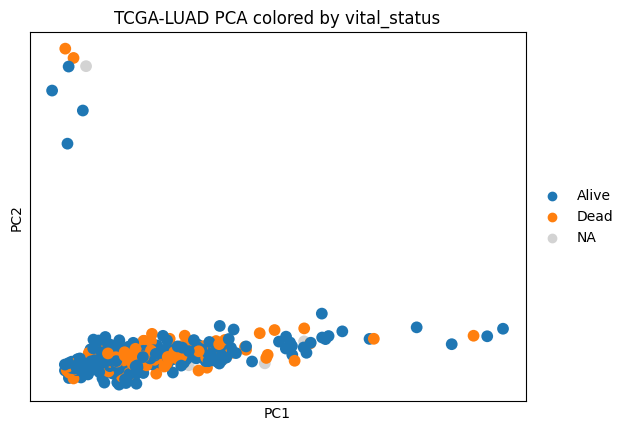

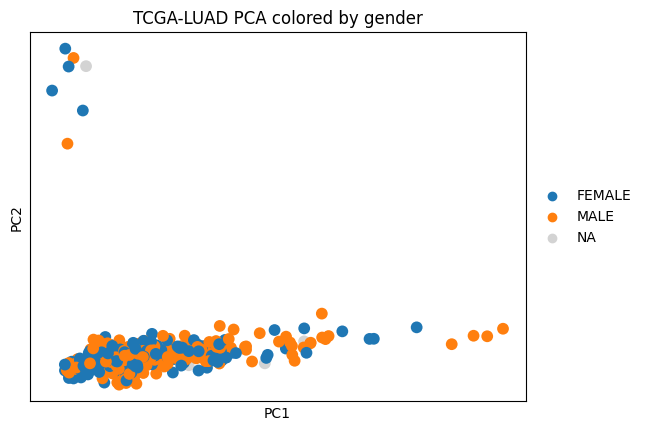

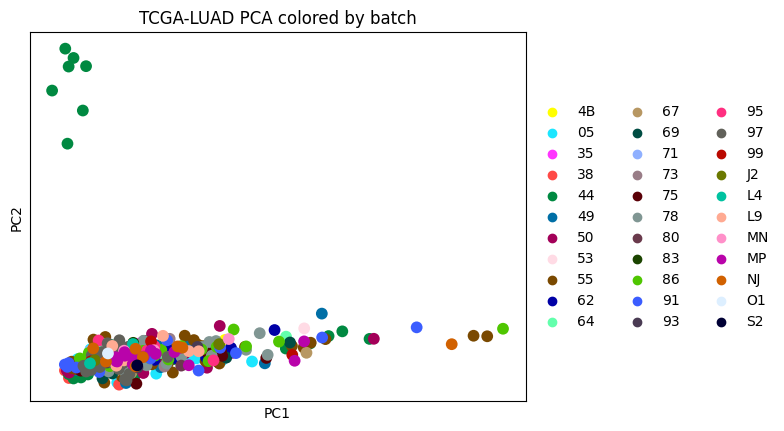

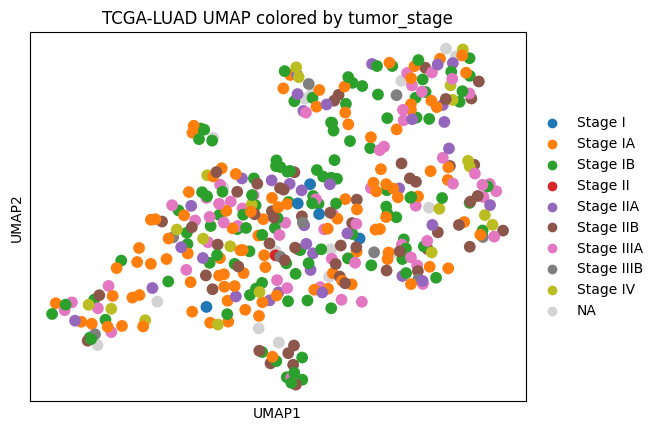

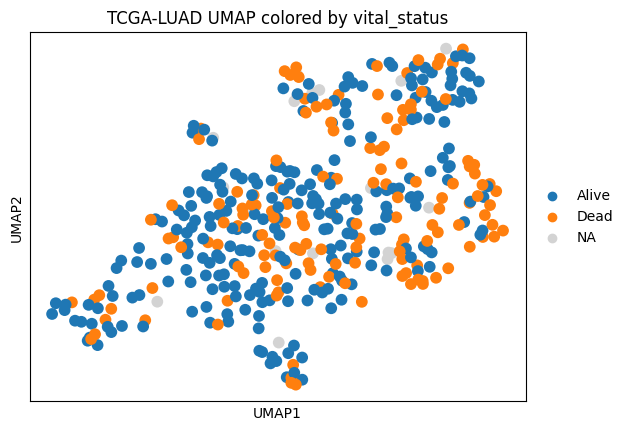

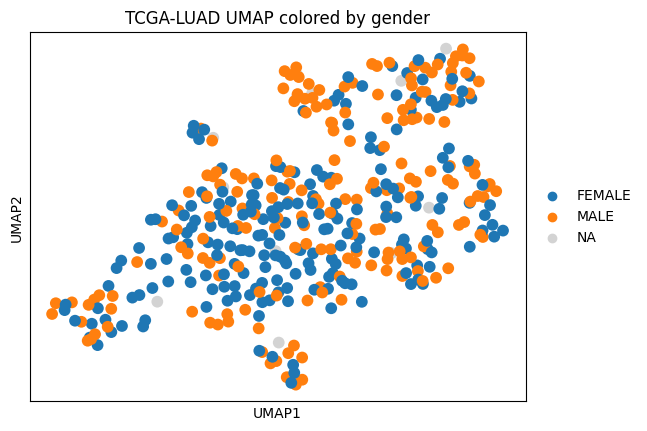

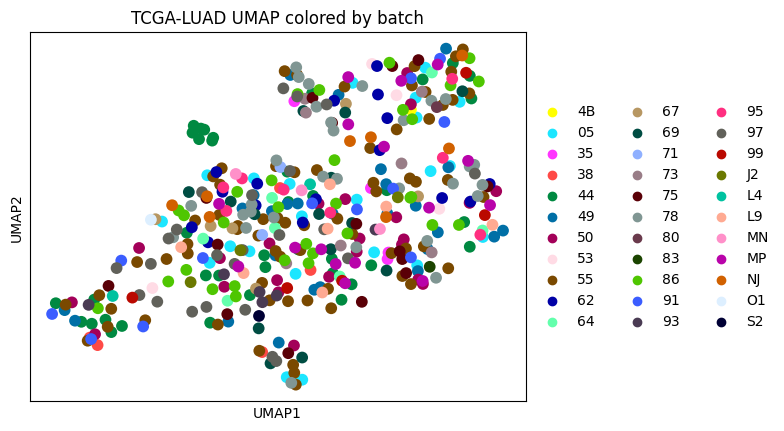

✅ Visualization complete for TCGA-LUAD.

📊 Visualizing: TCGA-LUSC
.obs columns: ['gender', 'age', 'vital_status', 'tumor_stage', 'batch']


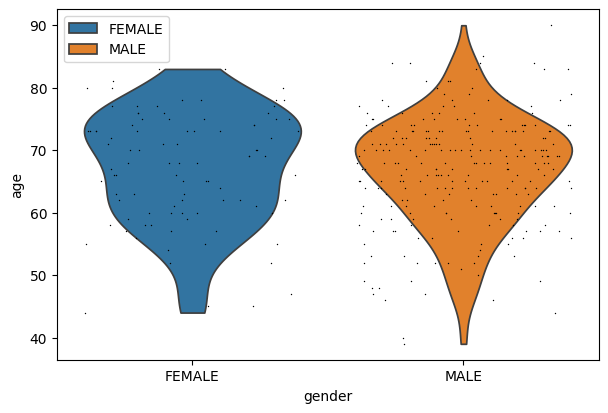

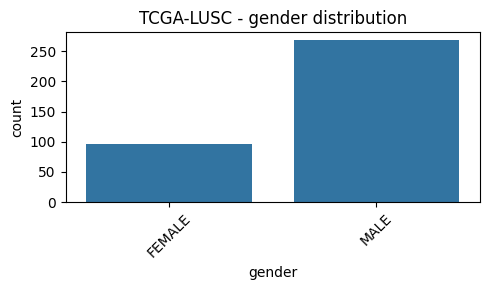

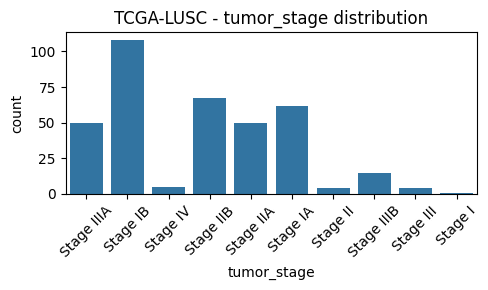

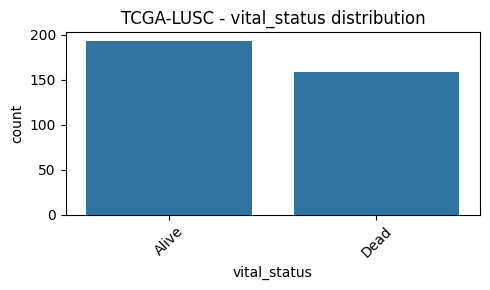

/home/ubuntu/.local/lib/python3.10/site-packages/scanpy/preprocessing/_scale.py:309: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
/usr/lib/python3.10/functools.py:889: UserWarning: zero-centering a sparse array/matrix densifies it.
  return dispatch(args[0].__class__)(*args, **kw)


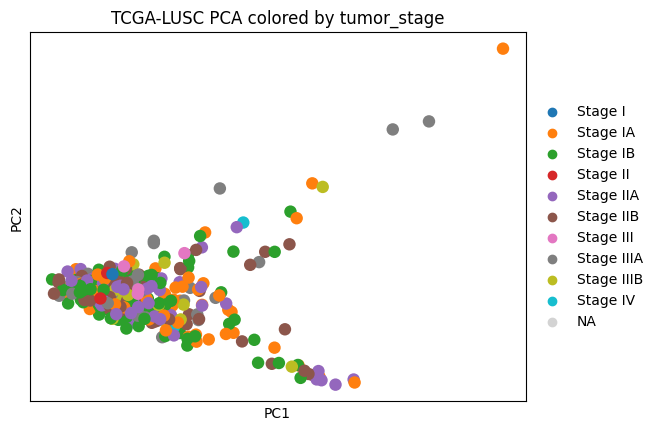

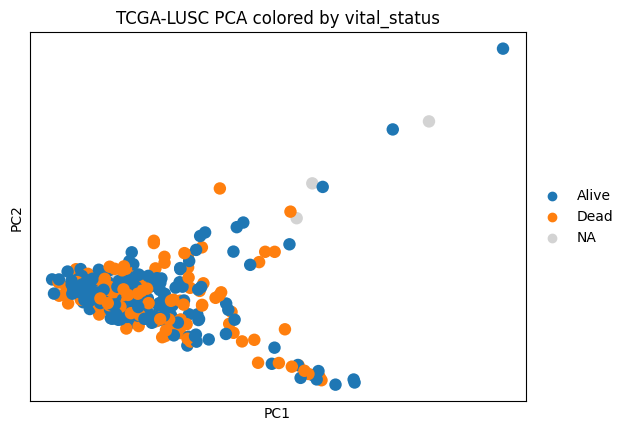

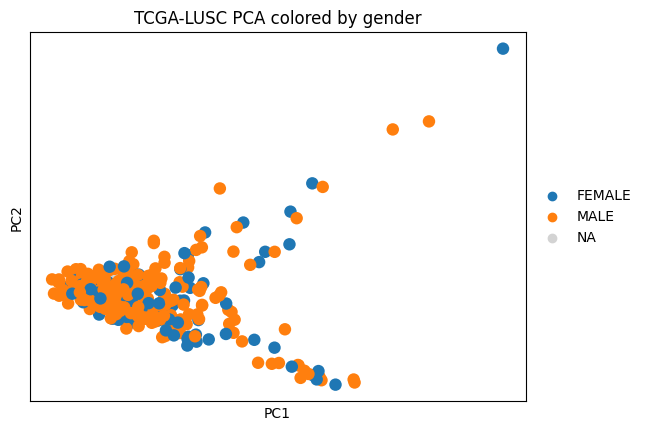

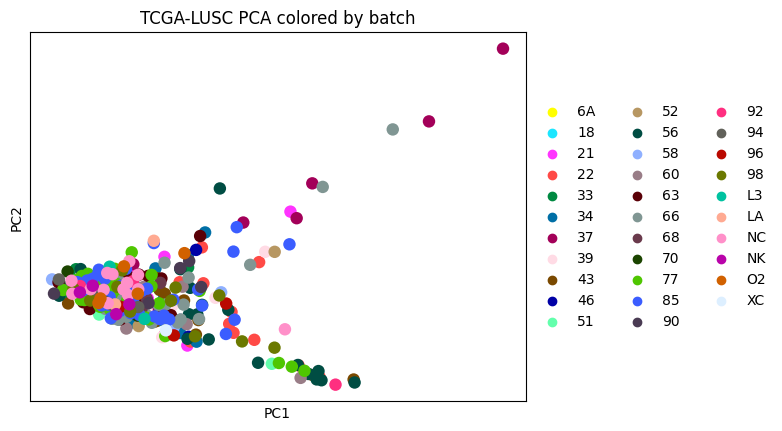

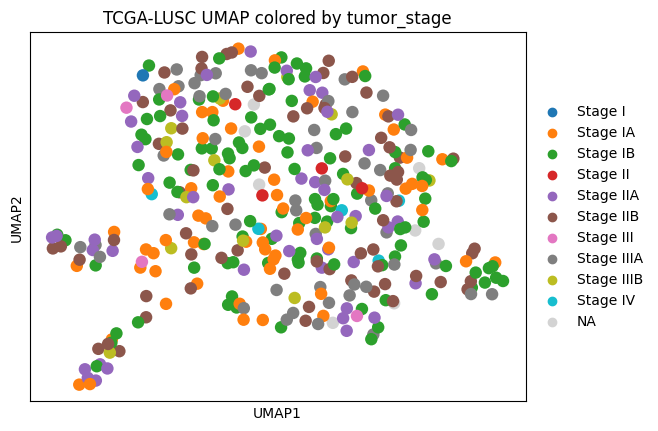

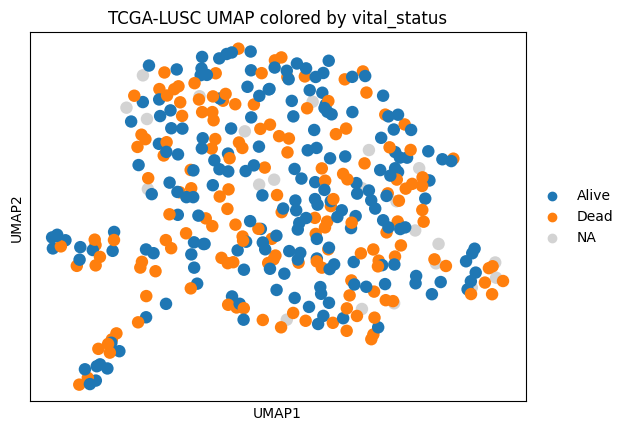

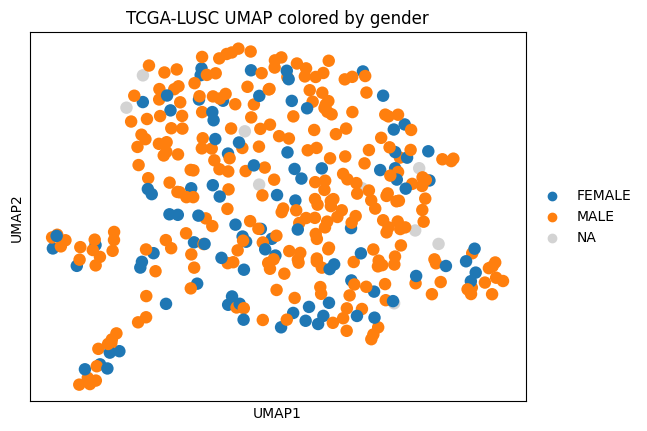

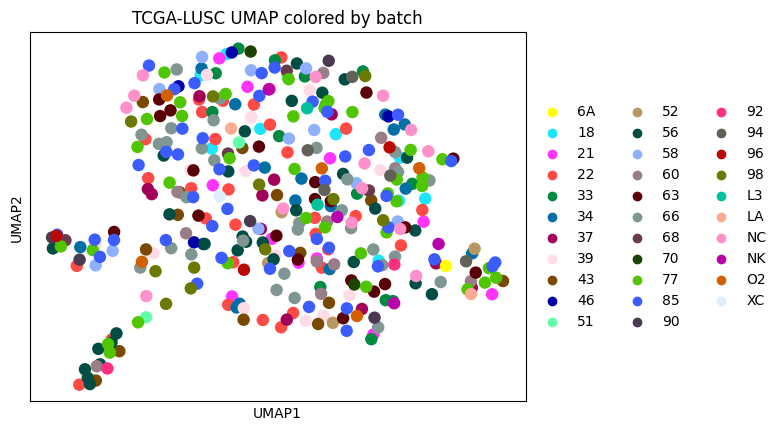

✅ Visualization complete for TCGA-LUSC.


In [3]:
import scanpy as sc
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def visualize_tcga(adata, dataset_name):
    print(f"\n📊 Visualizing: {dataset_name}")
    
    # Basic .obs inspection
    print(".obs columns:", adata.obs.columns.tolist())
    
    # 1. Violin plots for continuous features (age, optional: n_genes/n_counts if added)
    if 'age' in adata.obs.columns:
        sc.pl.violin(adata, keys=['age'], groupby='gender', jitter=0.4)

    # 2. Count categorical variables (gender, tumor_stage, vital_status)
    for cat in ['gender', 'tumor_stage', 'vital_status']:
        if cat in adata.obs.columns:
            plt.figure(figsize=(5, 3))
            sns.countplot(data=adata.obs, x=cat, order=adata.obs[cat].dropna().unique())
            plt.title(f"{dataset_name} - {cat} distribution")
            plt.xticks(rotation=45)
            plt.tight_layout()
            plt.show()

    # 3. PCA
    adata_tmp = adata.copy()
    sc.pp.normalize_total(adata_tmp, target_sum=1e6)
    sc.pp.log1p(adata_tmp)
    sc.pp.highly_variable_genes(adata_tmp, n_top_genes=2000)
    adata_tmp = adata_tmp[:, adata_tmp.var.highly_variable]
    sc.pp.scale(adata_tmp)
    sc.tl.pca(adata_tmp, svd_solver='arpack')
    
    color_options = [col for col in ['tumor_stage', 'vital_status', 'gender', 'batch'] if col in adata.obs.columns]
    if color_options:
        for col in color_options:
            sc.pl.pca(adata_tmp, color=col, title=f"{dataset_name} PCA colored by {col}")

    # Optional UMAP (if dataset size is moderate)
    sc.pp.neighbors(adata_tmp, n_neighbors=10, n_pcs=40)
    sc.tl.umap(adata_tmp)
    for col in color_options:
        sc.pl.umap(adata_tmp, color=col, title=f"{dataset_name} UMAP colored by {col}")

    print(f"✅ Visualization complete for {dataset_name}.")

# === Run for each TCGA dataset ===
adata_brca = sc.read_h5ad("../data/preprocessed/TCGA-BRCA_23_with_seq.h5ad")
adata_luad = sc.read_h5ad("../data/preprocessed/TCGA-LUAD_23_with_seq.h5ad")
adata_lusc = sc.read_h5ad("../data/preprocessed/TCGA-LUSC_23_with_seq.h5ad")

visualize_tcga(adata_brca, "TCGA-BRCA")
visualize_tcga(adata_luad, "TCGA-LUAD")
visualize_tcga(adata_lusc, "TCGA-LUSC")
